# Soft Actor Critic

Train a soft actor critic agent based on rl_coach framework : https://nervanasystems.github.io/coach/components/agents/policy_optimization/sac.html

Some "filters" are applied on observation before being supply to soft actor critic policies :
- Convert tensor uint8 type into float32
- Convert rgb images to grayscale
- Reshape image by cropping from (120, 160) -> (80, 160)
- Apply sobel filter (https://en.wikipedia.org/wiki/Sobel_operator)
  - Binarize images by setting elements to 0 or 1
- Embed image with variational auto encoder
- Concat last X actions

In [1]:
import os
import re
import tempfile

import pandas as pd
import matplotlib.pyplot as plt

import mlflow
import mlflow.keras

from rl_coach.agents.soft_actor_critic_agent import SoftActorCriticAgentParameters
from rl_coach.environments.gym_environment import GymVectorEnvironment
from rl_coach.graph_managers.basic_rl_graph_manager import BasicRLGraphManager
from rl_coach.graph_managers.graph_manager import SimpleSchedule
from rl_coach.base_parameters import TaskParameters, VisualizationParameters, PresetValidationParameters
from rl_coach.core_types import EnvironmentSteps, TrainingSteps, SelectedPhaseOnlyDumpFilter, RunPhase
from rl_coach.schedules import LinearSchedule

from rl_coach import logger

%matplotlib inline

In [2]:
# parameters
n_history = 20
improve_steps = 20000
heatup_steps = 300
evaluation_steps = 800
steps_between_evaluation_periods = 10000
num_training_per_episode = 1
vae_runid = "ad896cebfe4544e69e946d4f1bdc24aa"
checkpoint_path = None #"/workspace/mlruns/4/7f18a82d78a84cd58f7947bb4e3986ff/artifacts/17_Step-198210.ckpt"

In [7]:
# define the environment parameters
# Load VAE
vae = mlflow.keras.load_model(f"runs:/{vae_runid}/model", compile=False)
env_params = GymVectorEnvironment(level='xebikart.gym.envs:create_env')
env_params.additional_simulator_parameters = {
    'level': 4, 
    'frame_skip': 2, 
    'max_cte_error': 6.0, 
    'min_steering': -1,
    'max_steering': 1,
    'min_throttle': 0.2, 
    'max_throttle': 0.4,
    'vae': vae, 
    'n_history': n_history, 
    'max_steering_diff': 0.15, 
    'jerk_penalty_weight': 0.}

# Soft Actor Critic
agent_params = SoftActorCriticAgentParameters()
agent_params.algorithm.num_consecutive_training_steps = num_training_per_episode
agent_params.algorithm.act_for_full_episodes = True
agent_params.algorithm.heatup_using_network_decisions = checkpoint_path is not None
agent_params.algorithm.
# exploration schedules
agent_params.exploration.noise_schedule = LinearSchedule(0.1, 0., improve_steps)
agent_params.exploration.evaluation_noise = 0.


# visualize paremeters
vis_params = VisualizationParameters()
vis_params.print_networks_summary = True
vis_params.dump_parameters_documentation = True
vis_params.dump_mp4 = True
# Default rules, dump at evaluation phase when a new total reward has been achieved 
# Uncomment to dump all video during evaluation phase
#vis_params.video_dump_filters = [SelectedPhaseOnlyDumpFilter(RunPhase.TEST)]

# schedule
schedule_params = SimpleSchedule()
schedule_params.heatup_steps = EnvironmentSteps(heatup_steps)
schedule_params.improve_steps = TrainingSteps(improve_steps)
schedule_params.steps_between_evaluation_periods = EnvironmentSteps(steps_between_evaluation_periods)
schedule_params.evaluation_steps = EnvironmentSteps(evaluation_steps)

graph_manager = BasicRLGraphManager(
    agent_params=agent_params,
    env_params=env_params,
    vis_params=vis_params,
    schedule_params=schedule_params
)

preset_params = PresetValidationParameters()
preset_params.num_workers = 12

/usr/local/lib/python3.6/site-packages/tensorflow/python/keras/layers/core.py:891: UserWarning: xebikart.vae is not loaded, but a Lambda layer uses it. It may cause errors.
  , UserWarning)


TypeError: Parameter 'num_workers' does not exist in <class 'rl_coach.agents.soft_actor_critic_agent.SoftActorCriticAgentParameters'>. Parameters are only to be defined in a constructor of a class inheriting from Parameters. In order to explicitly register a new parameter outside of a constructor use register_var().

In [4]:
# Create temp directory
experiment_tempdir = tempfile.mkdtemp()

In [5]:
# create graph
task_params = TaskParameters()
task_params.num_gpu = 0
task_params.use_cpu = True
task_params.experiment_path = experiment_tempdir
task_params.checkpoint_save_dir = experiment_tempdir
# 30 min
task_params.checkpoint_save_secs = 60 * 30
# Use to start experiment from a checkpoint
task_params.checkpoint_restore_path = checkpoint_path

graph_manager.create_graph(task_params)

logger.experiment_path = graph_manager.graph_logger.experiments_path

Creating graph - name: BasicRLGraphManager
Looking in donkey_sim_home path: /sim/
Looking for file: /sim/DonkeySimLinux/donkey_sim.x86_64
Found: /sim/DonkeySimLinux/donkey_sim.x86_64
Starting DonkeyGym env
Donkey subprocess started
Binding to ('0.0.0.0', 9091)
Waiting for sim to start...if the simulation is running, press EXIT to go back to the menu
Got a new client ('127.0.0.1', 51176)
Scene Selection Ready
Connection dropped
Got a new client ('127.0.0.1', 51178)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Creating agent - name: agent

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.




Instructions for updating:
Use keras.l

In [6]:
mlflow.set_experiment("soft_actor_critic")

with mlflow.start_run():
    mlflow.log_param("improve_steps", improve_steps)
    mlflow.log_param("heatup_steps", heatup_steps)
    mlflow.log_param("evaluation_steps", evaluation_steps)
    mlflow.log_param("steps_between_evaluation_periods", steps_between_evaluation_periods)
    mlflow.log_param("num_training_per_episode", num_training_per_episode)
    mlflow.log_param("vae_runid", vae_runid)
    mlflow.log_param("n_history", n_history)
    mlflow.log_param("checkpoint", checkpoint_path)
    # TODO: think about saving the graph after improve
    # TODO: maybe not needed
    graph_manager.save_graph()
    graph_manager.improve()
    graph_manager.save_checkpoint()
    mlflow.log_artifacts(experiment_tempdir)
    # logs metrics
    agent_metrics = pd.read_csv(f"{experiment_tempdir}/worker_0.simple_rl_graph.main_level.main_level.agent_0.csv")
    mlflow.log_metric("episode_length_max", agent_metrics["Episode Length"].max())
    mlflow.log_metric("episode_length_mean", agent_metrics["Episode Length"].mean())
    mlflow.log_metric("episode_reward_max", agent_metrics["Training Reward"].max())
    mlflow.log_metric("episode_reward_mean", agent_metrics["Training Reward"].mean())

simple_rl_graph: Starting heatup
Heatup - Name: main_level/agent Worker: 0 Episode: 1 Total reward: 148.02 Steps: 151 Training iteration: 0 
Heatup - Name: main_level/agent Worker: 0 Episode: 2 Total reward: 136.15 Steps: 289 Training iteration: 0 
Heatup - Name: main_level/agent Worker: 0 Episode: 3 Total reward: 90.9 Steps: 385 Training iteration: 0 
Starting to improve simple_rl_graph task index 0
Training - Name: main_level/agent Worker: 0 Episode: 4 Total reward: 82.32 Steps: 474 Training iteration: 0 
Training - Name: main_level/agent Worker: 0 Episode: 5 Total reward: 71.91 Steps: 553 Training iteration: 1 
Training - Name: main_level/agent Worker: 0 Episode: 6 Total reward: 93.74 Steps: 653 Training iteration: 2 
Training - Name: main_level/agent Worker: 0 Episode: 7 Total reward: 129.92 Steps: 788 Training iteration: 3 
Training - Name: main_level/agent Worker: 0 Episode: 8 Total reward: 76.24 Steps: 872 Training iteration: 4 
Training - Name: main_level/agent Worker: 0 Episod

KeyboardInterrupt: 

### - Visualize Reward Evolution

In [ ]:
%%capture
list_file = os.listdir(logger.experiment_path)
csvfile = re.findall(pattern='[\w.]*.csv', string=' '.join(list_file))
df = pd.read_csv(os.path.join(logger.experiment_path, csvfile[0]))

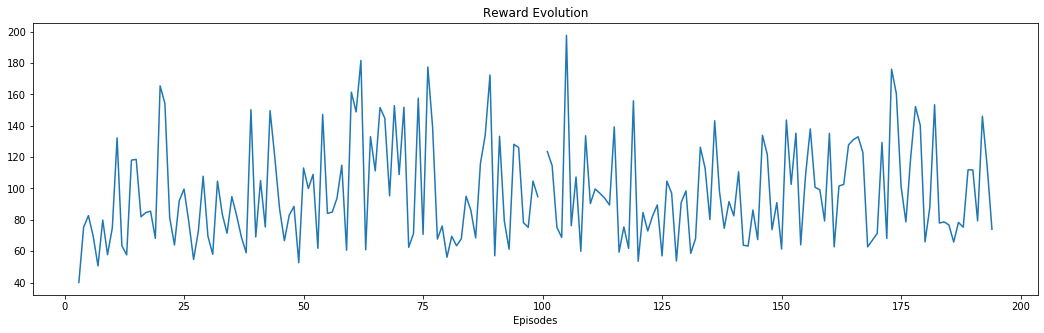

In [8]:
fig = plt.figure(figsize=(18,5))
plt.plot(df['Shaped Training Reward'])
plt.title('Reward Evolution')
plt.xlabel('Episodes')

plt.show()

In [53]:
df.head()

,Episode #,Training Iter,Epoch,In Heatup,ER #Transitions,ER #Episodes,Episode Length,Total steps,Epsilon,Shaped Training Reward,...,V_tgt_ns/Max,V_tgt_ns/Min,V_onl_ys/Mean,V_onl_ys/Stdev,V_onl_ys/Max,V_onl_ys/Min,actions/Mean,actions/Stdev,actions/Max,actions/Min
0,1,0.0,0.0,1.0,83.0,83.0,83.0,83.0,0.1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,0.0,0.0,1.0,176.0,176.0,93.0,176.0,0.1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,0.0,0.0,1.0,284.0,284.0,108.0,284.0,0.1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,0.0,0.0,1.0,388.0,388.0,104.0,388.0,0.1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,0.0,0.0,0.0,502.0,502.0,114.0,502.0,0.1,106.746385,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.151595,0.581465,0.958505,-0.996347


In [7]:
graph_manager.close()

Closing donkey sim subprocess
Server shutdown
Connection dropped
